In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import pickle
import seaborn as sns
import sys
import numpy as np
import scipy.optimize as op
from scipy.optimize import curve_fit

sns.set_palette("PuBuGn_d",15)
sns.set_style("whitegrid")
import emcee


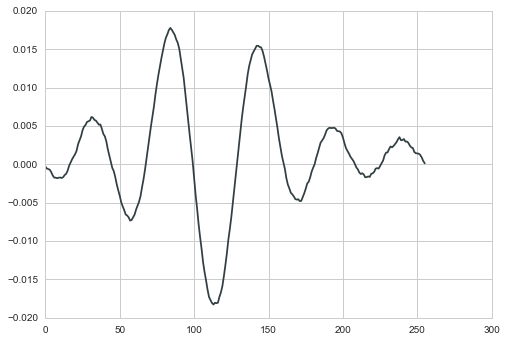

In [2]:
file=open( '../../data/raw_data/20160802_1643_1.4xII.1xIII.6_40mms.pkl' , 'rb')
#   20160428_1313_W1204_ref.pkl
d=pickle.load(file)
file.close()

i = 8
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize #ending point


df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0


y = (d['sig0F']) 
D = y[startpt:endpt]
#D = np.flipud(D)

a = d['delay0F']/v
t = a[startpt:endpt]

pl.plot(D)

In [3]:
#model function convoluted with RC circuit and AC coupling function
def psi1(znot,q,p,T):
    Ns = 256
    z = t
    dz = z[2]-z[1]
    f = np.linspace(0,0.5/dz, np.floor(Ns/2))
    f_full = np.linspace(0,0.5/dz, np.floor(Ns/2) +1)
    #original function
    y0=-np.cos(2*np.pi*q*(z-znot))*(np.exp(-((z-znot)**2)/(2*p**2)))/(np.sqrt(2*np.pi)*p)
    yf0=np.fft.rfft(y0)
    K_det =(1/(1+(1j*2*np.pi*f_full*T))) #kernel from detector
    K_cc =(2*np.pi*f_full*.559)/(1 + (1j*2*np.pi*.559)) #kernel from AC coupling
    K_f = np.multiply(K_det,K_cc)
    y1=np.fft.irfft(yf0*K_f*2*np.pi)
    return t,y1
#znot = 0.012, q = 8.57718120805, p = .04

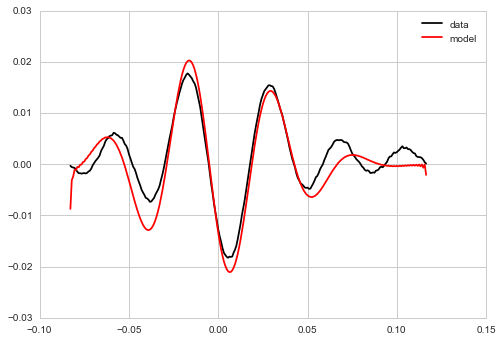

In [4]:
pl.plot(t,D, color = 'black', label = 'data')
t,Model = psi1(-.0039,20,0.035, 0.001)
pl.plot(t,Model*.000016, color = 'red', label = 'model')
pl.legend()

In [5]:
#likelihood function
#why is it ln?
def lnlike(params, t, D):
    znot, q, p, T, a = params 
    t,Modelf = psi1(znot,q,p, T)
    Dev = -.5*(np.dot((D-Modelf*a),D-Modelf*a))
    Sig=0.0005
    return (Dev/Sig)-np.log(1/Sig) #sigma? if sigma is large it becomes shallower

In [6]:
nll = lambda *args: -lnlike(*args) 
result = op.minimize(nll, [-.0039,20,0.035, 0.001, .000016], args=(t,D))
znot1,q1,p1,T1,a1 = result["x"]
print result ["x"]

[ -3.90000000e-03   2.00000000e+01   3.50000000e-02   1.00000000e-03
   1.60000000e-05]


In [7]:
#prior function
#again, why is it ln?
def lnprior(params):
    znot, q, p, T, a = params 
    #-.0039,20,0.035, 0.001
    if -.03 < znot < 0.01 and 15 < q < 28 and .01 < p < .1 and 0 < T < 0.9 and 0.0 < a < .001:
        return 0.0
    return -np.inf 
    #set znot to some delay because then tau  must move to accomodate as opposed to znot doing so. 
    #center znot at zero. (-.00001<z<.000001)
    #

In [8]:
#log probability function
def lnprob (params, t, D):
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(params, t, D)

In [9]:
ndim, nwalkers = 5,260
pos = [result["x"] + 10**(-4)*np.random.randn(ndim) for i in range(nwalkers)]

In [10]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob, args=(t,D))

In [11]:
sampler.run_mcmc(pos, 4000); #number of steps

(260, 4000, 5)


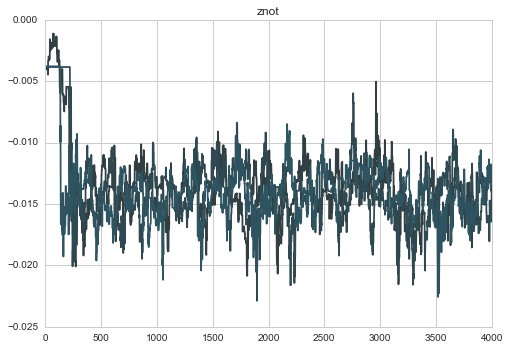

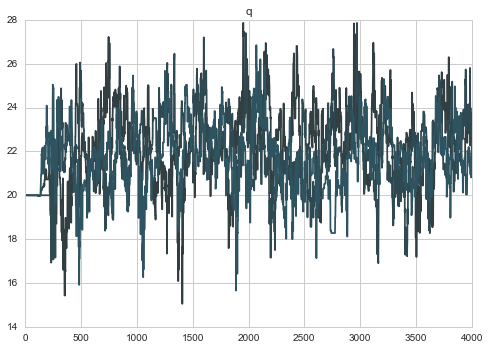

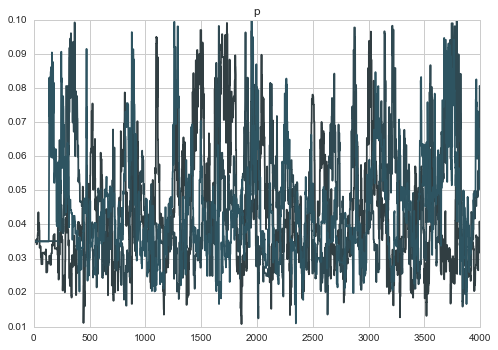

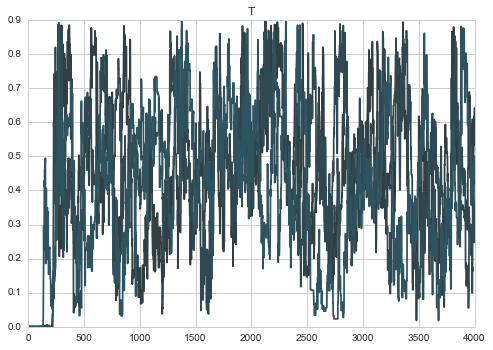

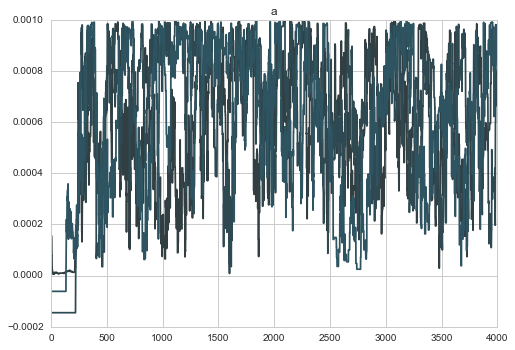

In [12]:
walks=(sampler.chain)
print(np.shape(walks))

for nn in range(0,ndim):
    pl.plot(walks[0,:,nn])
    pl.plot(walks[1,:,nn])
    pl.plot(walks[2,:,nn])
    titles = ['znot','q','p','T','a']
    pl.title(titles[nn])
    pl.show() #sigma = .001

In [13]:
samples = sampler.chain[:,1000:,:].reshape([-1, ndim])
print(np.shape(samples)) #treating all walkers as experiments
batman=sampler.chain[:,1000:,:]
print(np.shape(batman))
#5: number of variables, 3000: number of data points/experiments run, 260: number of walkers

(780000, 5)
(260, 3000, 5)


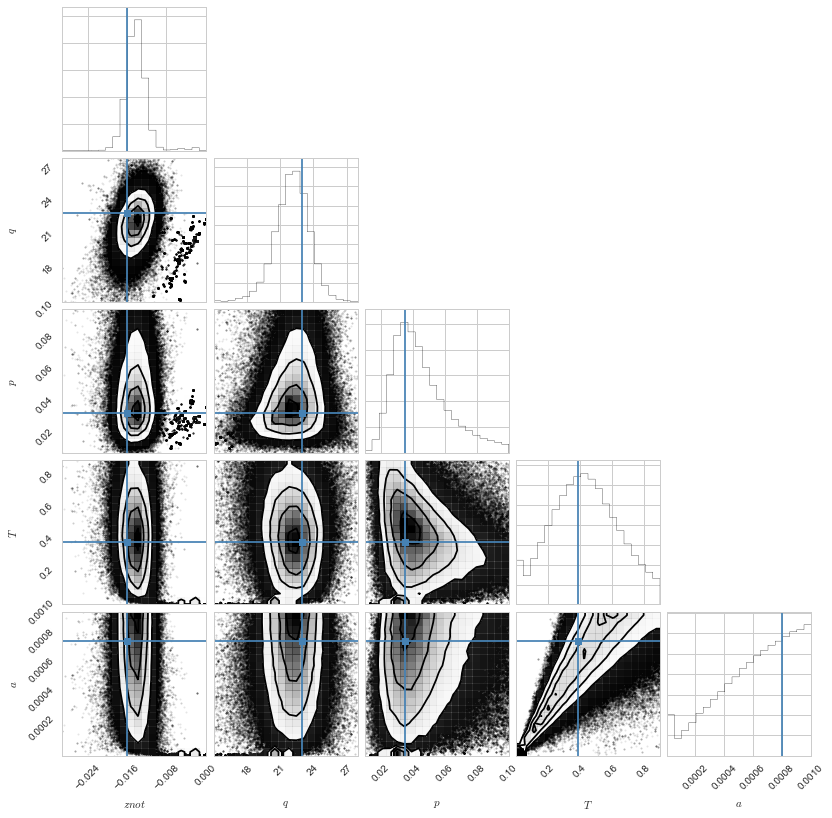

In [14]:
import corner
fig = corner.corner(samples, labels=["$znot$","$q$", "$p$", "$T$", "$a$"], 
                    truths=[-.016, 23, .035, .39, .0008]) #znot: -.02
fig.savefig("MCMCattempt2.png")

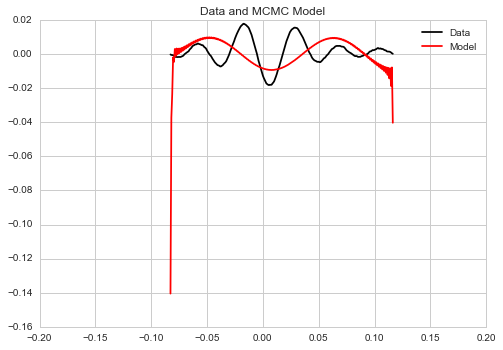

In [15]:
pl.plot(t,D, label = 'Data', color = 'black')
x,Modelf = psi1(-.016,9.01,1.039,0.001) #z,q,p,T
pl.plot(x,Modelf*.00045, label = 'Model', color = 'red') #a
pl.xlim(-.2,.2)
pl.title('Data and MCMC Model')
pl.legend()
pl.show()

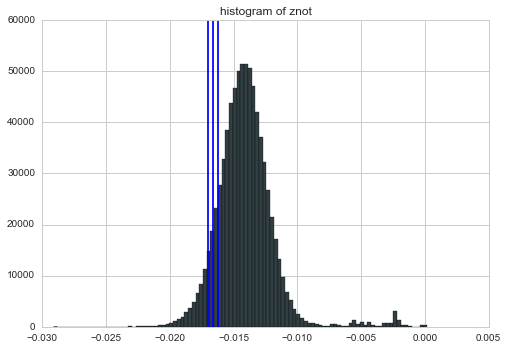

In [16]:
#histogram of znot
pl.hist(samples[:,0], 100,)
pl.title('histogram of znot')
pl.axvline(x = -0.016625410219655516)
pl.axvline(x = -.017)
pl.axvline(x = -.0162)
pl.show()

In [17]:
np.mean(samples[:,0])

-0.014072000712445326

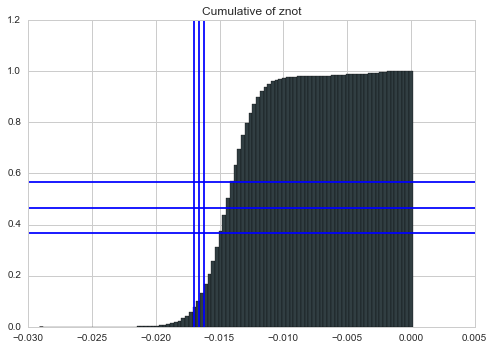

In [18]:
#cumulative plot of znot
pl.hist(samples[:,0], 100, normed = 1,  cumulative = True)
#pl.xlim(-.022, -.014)
pl.axvline(x = -0.016625410219655516)
pl.axhline(y = .465)
pl.axhline(y = .565)
pl.axhline(y = .365)

pl.axvline(x = -.017)
pl.axvline(x = -.0162)
pl.title('Cumulative of znot')
pl.show()



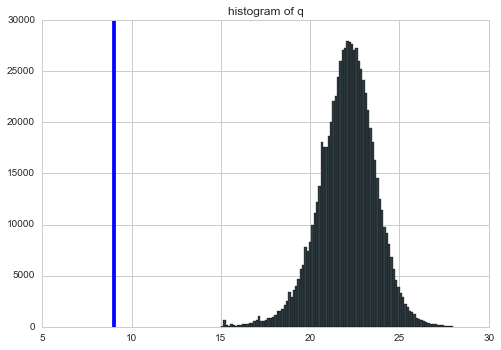

In [19]:
#histogram of q
pl.hist(samples[:,1], 100,)
pl.title('histogram of q')
pl.axvline(x = 9.0088402088723747)
pl.axvline(x = 9.06)
pl.axvline(x = 8.95)
pl.show()

In [20]:
np.mean(samples[:,1])

22.076507347267714

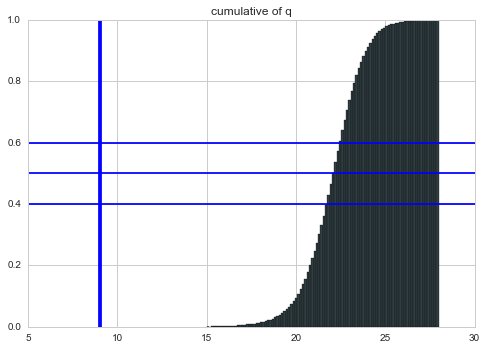

In [21]:
#cumulative plot of q
pl.hist(samples[:,1], 100, normed = 1,  cumulative = True)
pl.axvline(x = 9.0088402088723747)
pl.axhline(y = .5)
pl.axhline(y = .6)
pl.axhline(y = .4)

pl.axvline(x = 9.06)
pl.axvline(x = 8.95)
pl.title('cumulative of q')
pl.show()

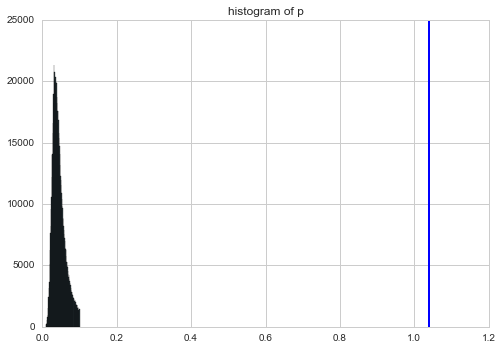

In [22]:
#histogram of p
pl.hist(samples[:,2], 100,)
pl.title('histogram of p')
pl.axvline(x = 1.0390388013045118)
pl.axvline(x = 1.0387)
pl.axvline(x = 1.0395)
pl.show()

In [23]:
np.mean(samples[:,2])

0.045219890809127333

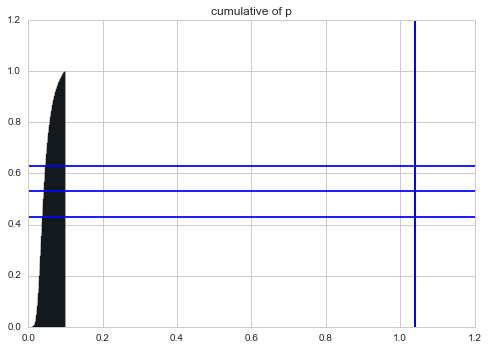

In [24]:
#cumulative plot of p
pl.hist(samples[:,2], 100, normed = 1,  cumulative = True)
pl.axvline(x = 1.0390388013045118)

pl.axhline(y = .53)
pl.axhline(y = .63)
pl.axhline(y = .43)

pl.axvline(x = 1.0387)
pl.axvline(x = 1.0395)

pl.title('cumulative of p')
pl.show()

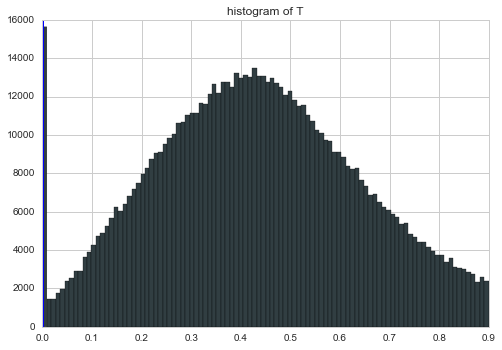

In [25]:
#histogram of T
pl.hist(samples[:,3], 100,)
pl.title('histogram of T')
pl.axvline(x = 0.0017997865269232592)
pl.axvline(x = .00146)
pl.axvline(x = .0023)
pl.show()

In [26]:
np.mean(samples[:,3])

0.43182065435660272

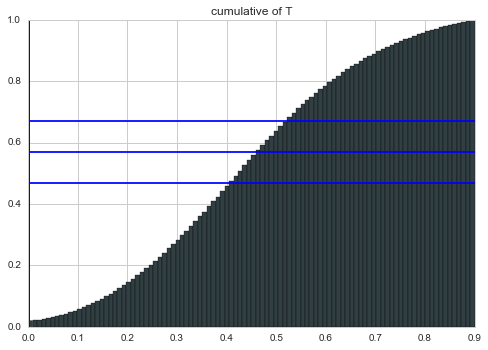

In [27]:
#cumulative plot of T
pl.hist(samples[:,3], 100, normed = 1,  cumulative = True)
pl.axvline(x = 0.0017997865269232592)

pl.axhline(y = .57)
pl.axhline(y = .67)
pl.axhline(y = .47)

pl.axvline(x = .00146)
pl.axvline(x = .0023)

pl.title('cumulative of T')
pl.show()

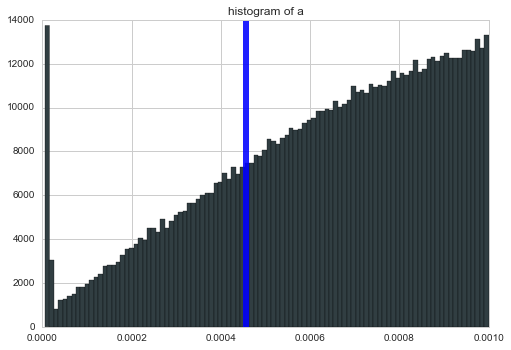

In [28]:
#histogram of a
pl.hist(samples[:,4], 100,)
pl.title('histogram of a')
pl.axvline(x = 0.0004564326299358209)
pl.axvline(x = .000452)
pl.axvline(x = .00046)
pl.show()

In [29]:
np.mean(samples[:,4])

0.00062981396916541308

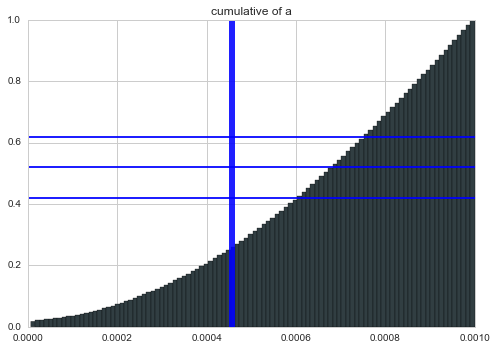

In [30]:
#cumulative plot of a
pl.hist(samples[:,4], 100, normed = 1,  cumulative = True)
pl.axvline(x = 0.0004564326299358209)

pl.axhline(y = .52)
pl.axhline(y = .62)
pl.axhline(y = .42)

pl.axvline(x = .000452)
pl.axvline(x = .00046)

pl.title('cumulative of a')
pl.show()